In [1]:
from os.path import abspath
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inspect

In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [3]:
# create database
# File location and type
file_location_array = [
    {"location" : "../../training/pred_tremi_full.csv", "name": "pred_tremi_full", "delimiter": ","},
    {"location" :  "../../training/training_dpe.csv", "name": "training_dpe", "delimiter": ","},
    {"location" :  "../../training/prediction_dpe.csv", "name": "prediction_dpe", "delimiter": ","},
    {"location" :  "../../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type) \
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )
    dataframes[file["name"]].show()

+------+---+----------+----------+---------------+------+----------+---------------------+----------------------+---------------+---------------------+-----------------+-------+------------------+----------------+
|gender|age|occupation|home_state|nb_persons_home|income|population|n_development_licence|n_construction_licence|n_new_buildings|n_destruction_licence|department_number|surface|heating_production|heating_emission|
+------+---+----------+----------+---------------+------+----------+---------------------+----------------------+---------------+---------------------+-----------------+-------+------------------+----------------+
|     0| 39|        13|         0|              3|     4|     12368|                    4|                    41|             43|                    0|               50|   null|              null|            null|
|     1| 26|        14|         0|              1|     1|    115934|                    5|                    78|            702|               

In [4]:
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface' : F.col('surface').cast('float'),
        'heating_production' : F.col('heating_production').cast('int'),
        'heating_emission' : F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [5]:

training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop('heating_emission', 'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop('heating_emission', 'heating_production')

training_prod = training_tremi.filter(F.col('heating_production').isNotNull()).drop('heating_emission', 'surface')
predicting_prod = training_tremi.filter(F.col('heating_production').isNull()).drop('heating_emission', 'surface')

training_em = training_tremi.filter(F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')
predicting_em = training_tremi.filter(F.col('heating_emission').isNull()).drop('surface', 'heating_production')

print(training_surf.count(), predicting_surf.count(), training_prod.count(), predicting_prod.count(), training_em.count(), predicting_em.count())

12565 26933 11128 28370 12558 26940


In [6]:
# get the name of  variable outside fonction
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

# cut variable name if too long
def cut(name):
    if isinstance(name, str) and len(name)>25:
        return name[0:25]
    return name

# get all values in dict form
def get_dict(df):
    col_names = [col[0] for col in df.dtypes]
    values = {}
    rows = df.collect()
    for col_name in col_names:
        values[col_name] = [cut(row[col_name]) for row in rows]
    return values

# get labels for a variable thanks to dictionary
def get_labels(variable):
    study = (
        dictionary.filter(
            (F.col('column') == variable) &
            (~F.col('value').contains('-'))
        )
        .select(
            F.col('value'),
            F.col('meaning')
        )
        .dropDuplicates()
        .orderBy(F.col('value').cast('int'))
    )
    return get_dict(study)

# return ticks for pie
def get_percent(value, values):
    total = sum(values)
    if len(values) < 5:
        return f'{value/100*total:.0f}\n{value:.2f}%'
    else:
        return f'{value:.1f}'

# plot pie
def plot_repartition(df, variable, ax, title=None):
    labels = get_labels(variable)['meaning']
    count = get_dict(df.withColumn(variable, F.col(variable).cast(int)).groupBy(variable).count().orderBy(variable))['count']
    ax.pie(count, labels = labels, autopct=lambda x: get_percent(x,count),startangle=90)
    if title:
        ax.set_title(title)

# plot_hist
def plot_hist(df, variable, ax, title=None):
    
    labels = get_labels(variable)['meaning']
    values = get_dict(df.groupBy(variable).count().orderBy(variable))
    total = sum(values['count'])
    percent = [value * 100 / total for value in values['count']]
    x = values[variable]
    min_value = int(min(values[variable]))

    # bar graph
    bars = ax.bar(x=x, height = percent, width=0.5)
    ax.set_xticks(range(min_value, len(labels) + min_value), labels, rotation = 90)

    # set y ticks
    vals = ax.get_yticks()
    ax.set_yticklabels(['%1.2f%%' %i for i in vals])

    # plot percentage
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.1f}%",(bar.get_x() + bar.get_width()/2, height+.05),ha="center",va="bottom",fontsize=10)

    # title
    if title:
        ax.set_title(title)

# plot multiple chart
def compare_repartition(dfs, variable):
    f, ax = plt.subplots(1, len(dfs), figsize=(20,5), sharey=True)
    plt.subplots_adjust(wspace=0.2)
    if len(dfs) > 1:
        for i, df in enumerate(dfs):
            plot_hist(df, variable, ax[i], retrieve_name(df))
    else:
        plot_hist(dfs[0], variable, ax, retrieve_name(dfs[0]))

# input variables

C:\Users\arocheteau\AppData\Local\Temp\ipykernel_3428\1270471585.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


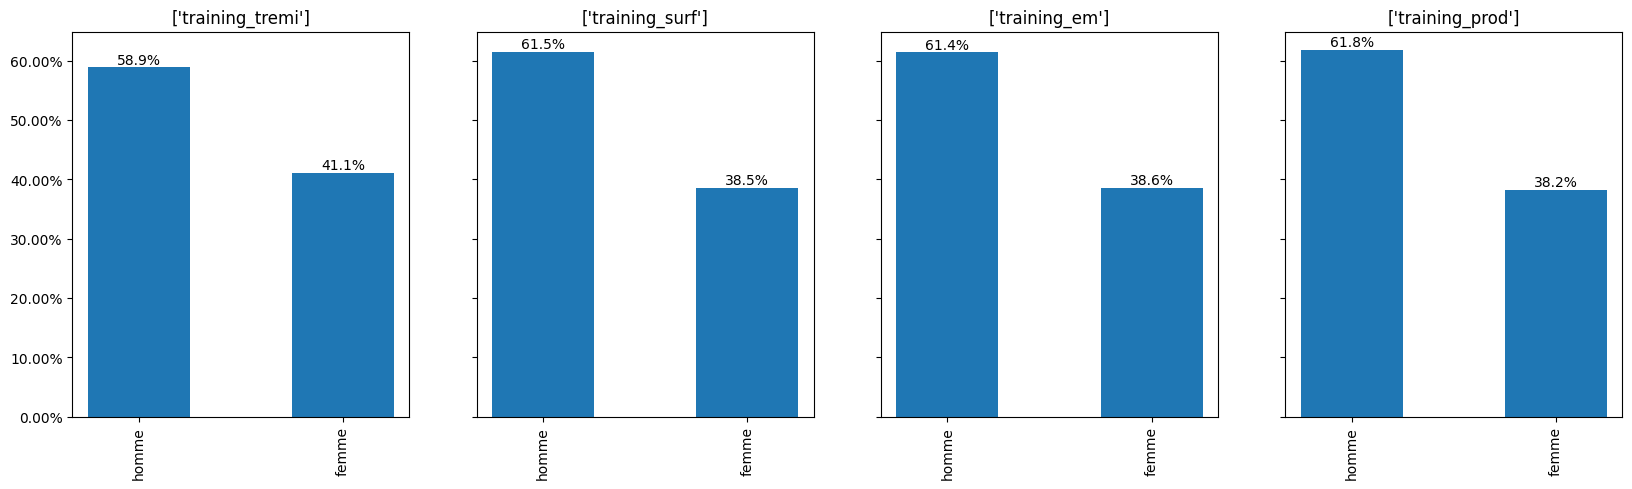

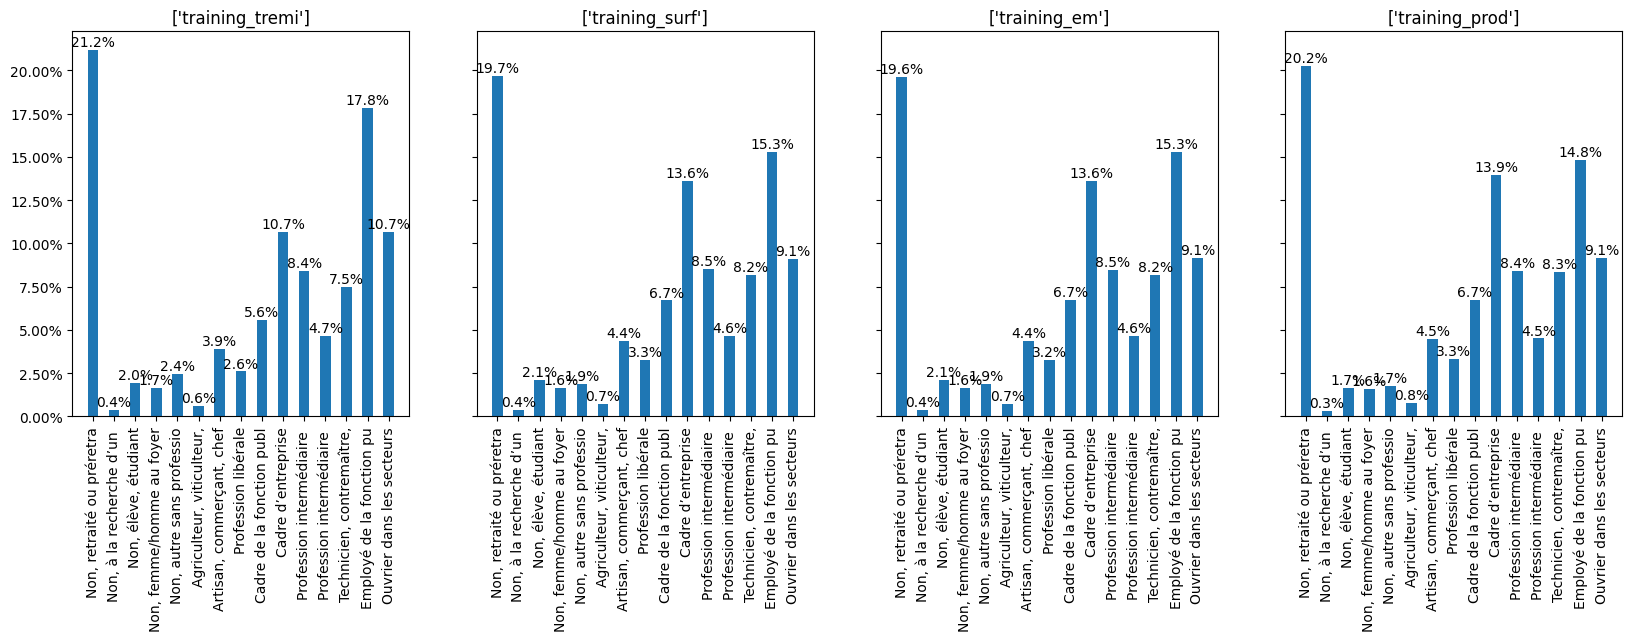

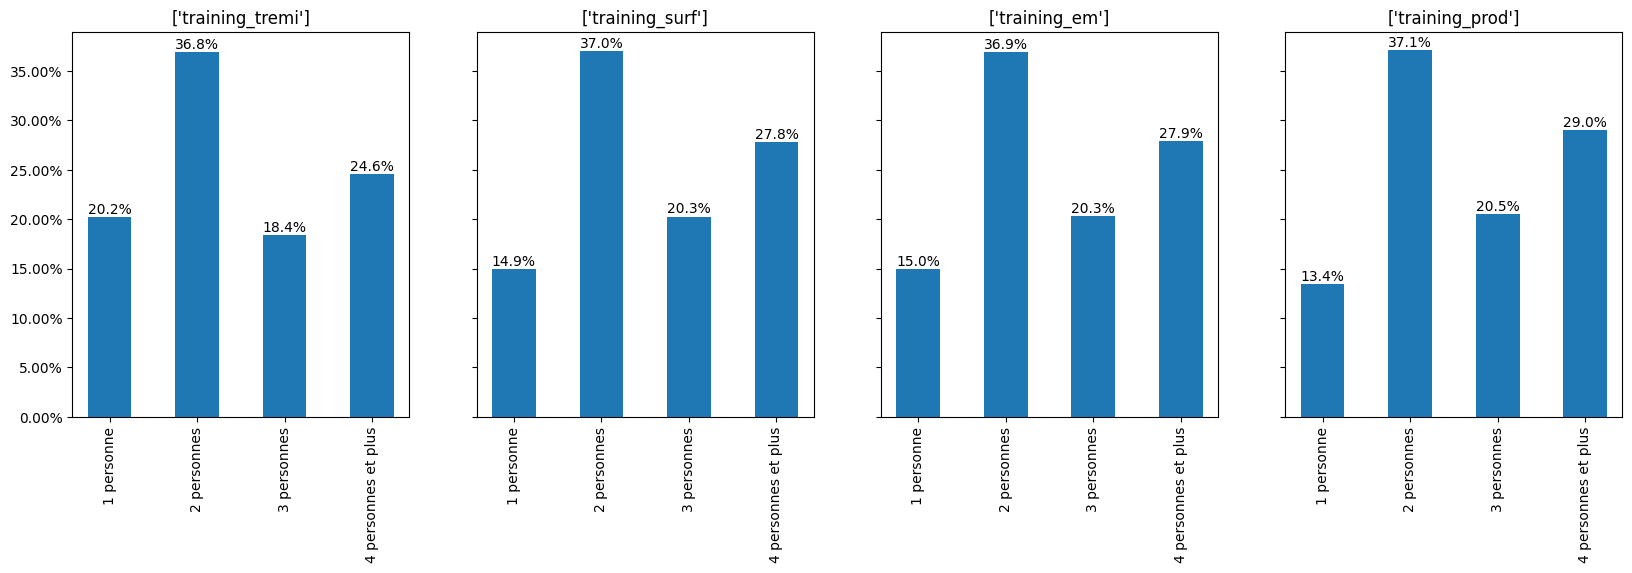

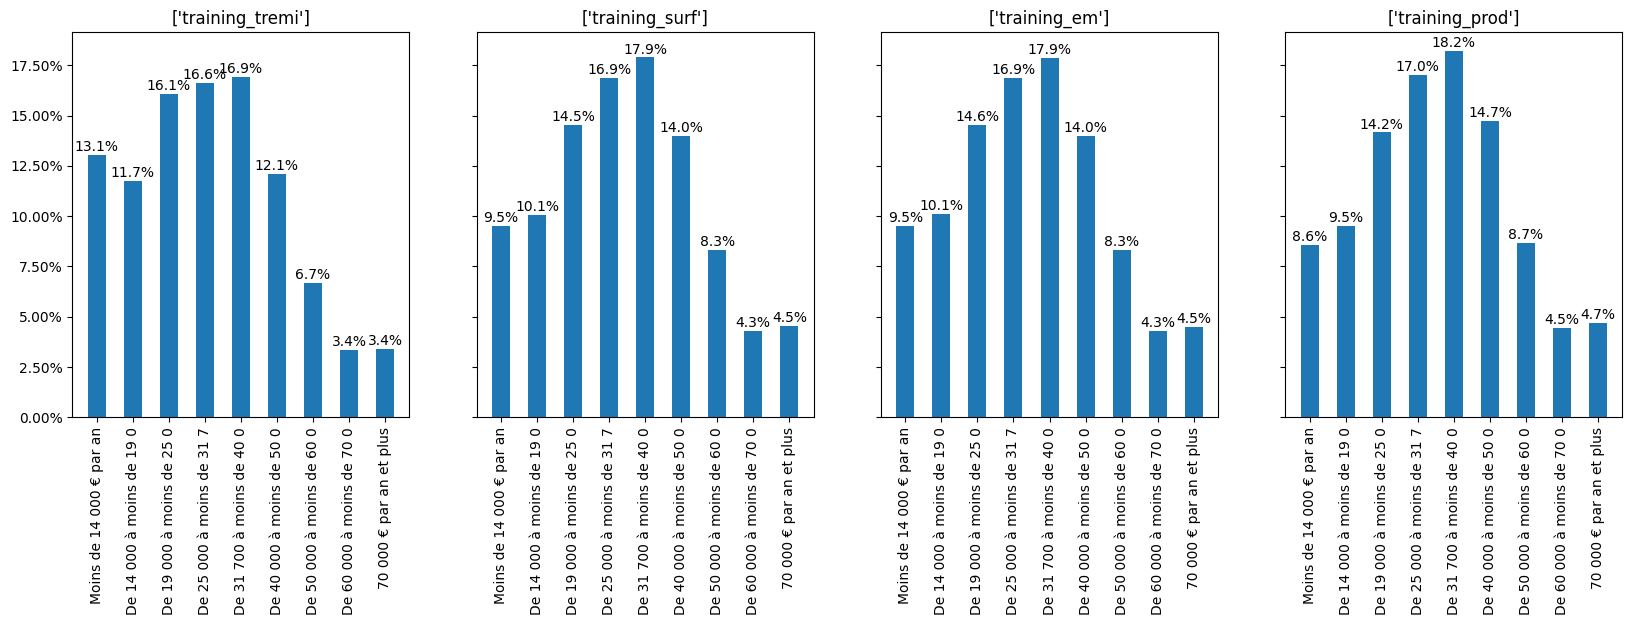

In [7]:
dfs = [training_tremi, training_surf, training_em, training_prod]
compare_repartition(dfs, 'gender')
compare_repartition(dfs, 'occupation')
compare_repartition(dfs, 'nb_persons_home')
compare_repartition(dfs, 'income')

In [8]:
def histo(df, variable, bins = 20):
    plt.title(variable)
    plt.hist(df.select(variable).toPandas(), bins=bins)
    plt.show()

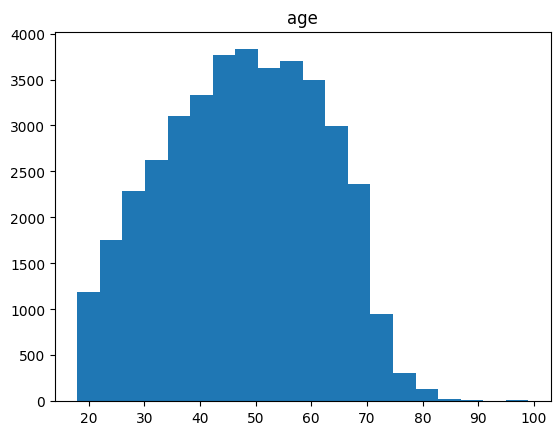

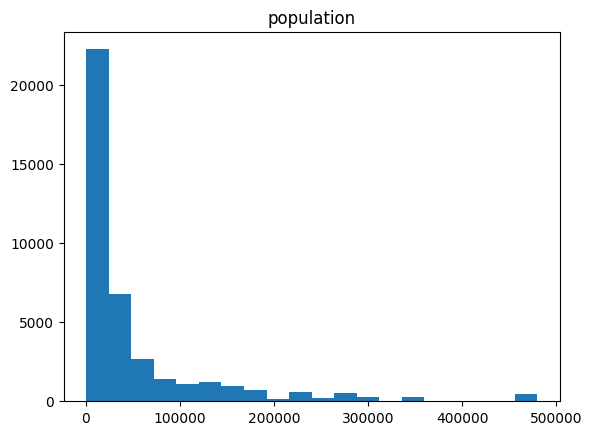

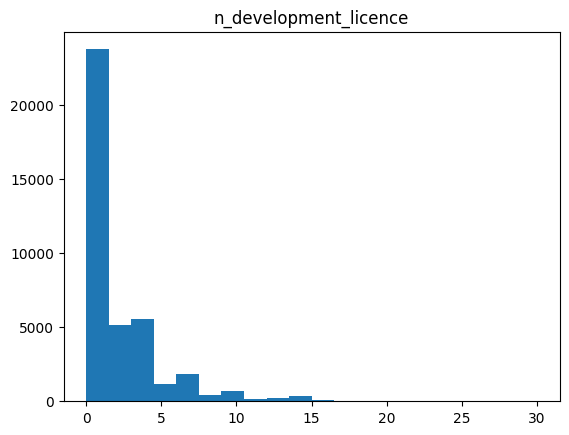

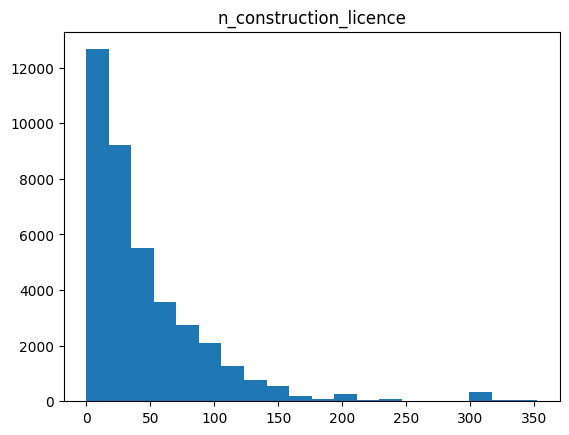

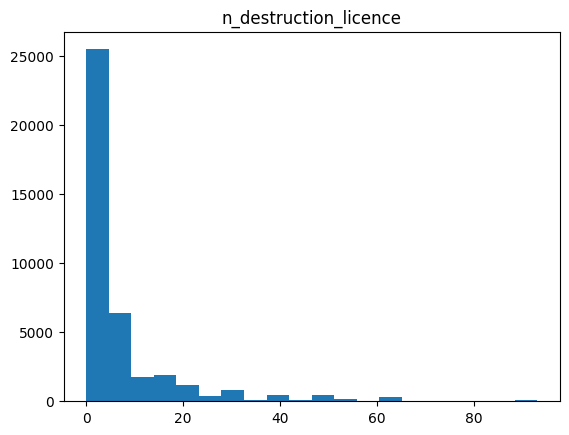

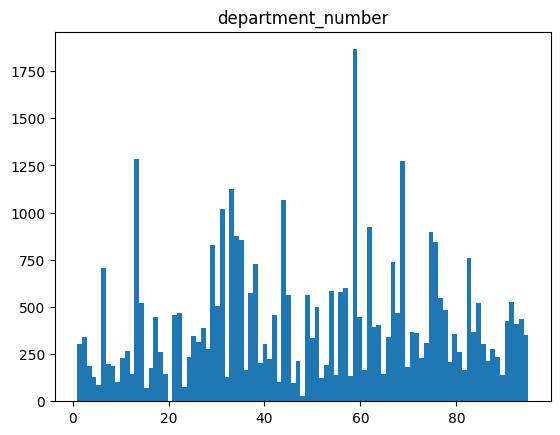

In [9]:
histo(training_tremi, 'age')
histo(training_tremi, 'population')
histo(training_tremi, 'n_development_licence')
histo(training_tremi, 'n_construction_licence')
histo(training_tremi, 'n_destruction_licence')
histo(training_tremi, 'department_number', 95)

# ouput variables

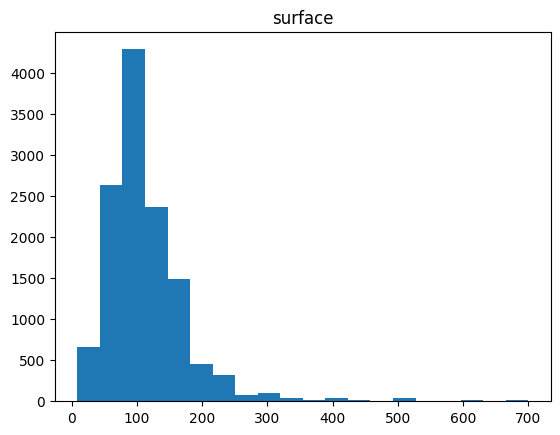

C:\Users\arocheteau\AppData\Local\Temp\ipykernel_3428\1270471585.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


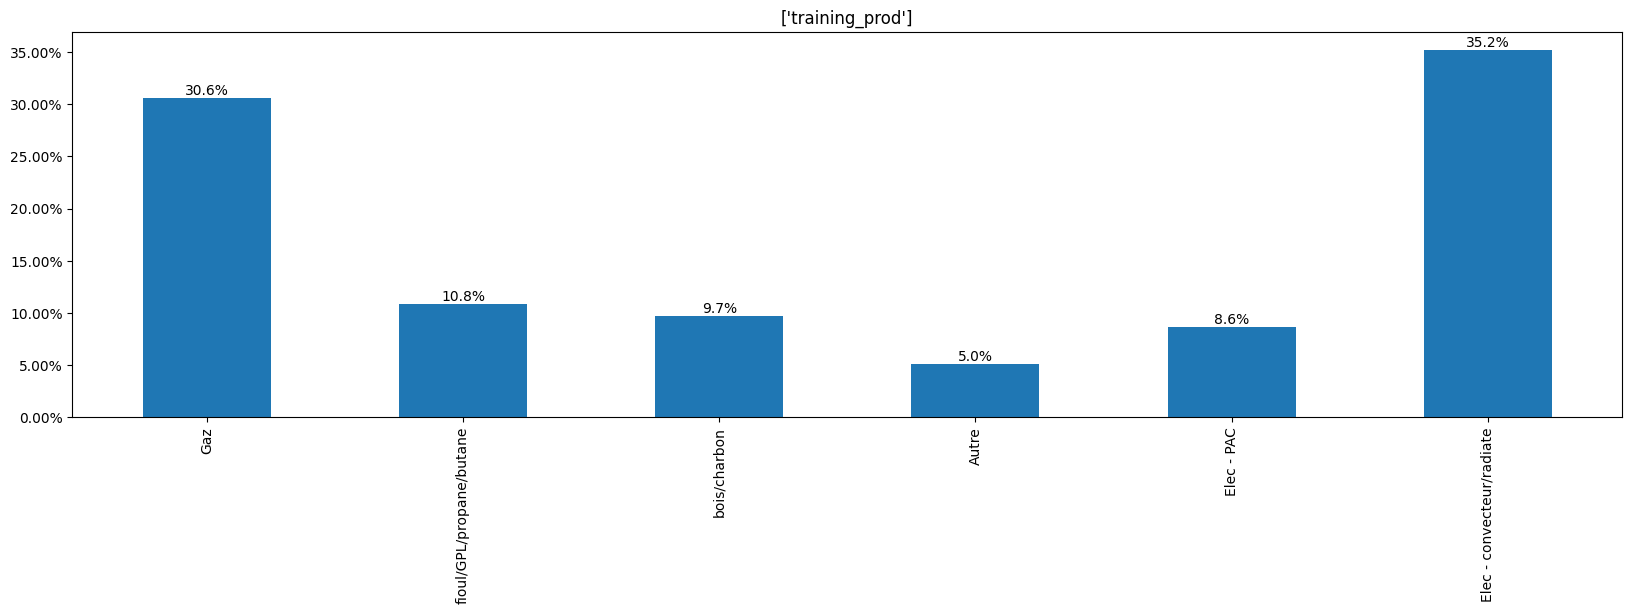

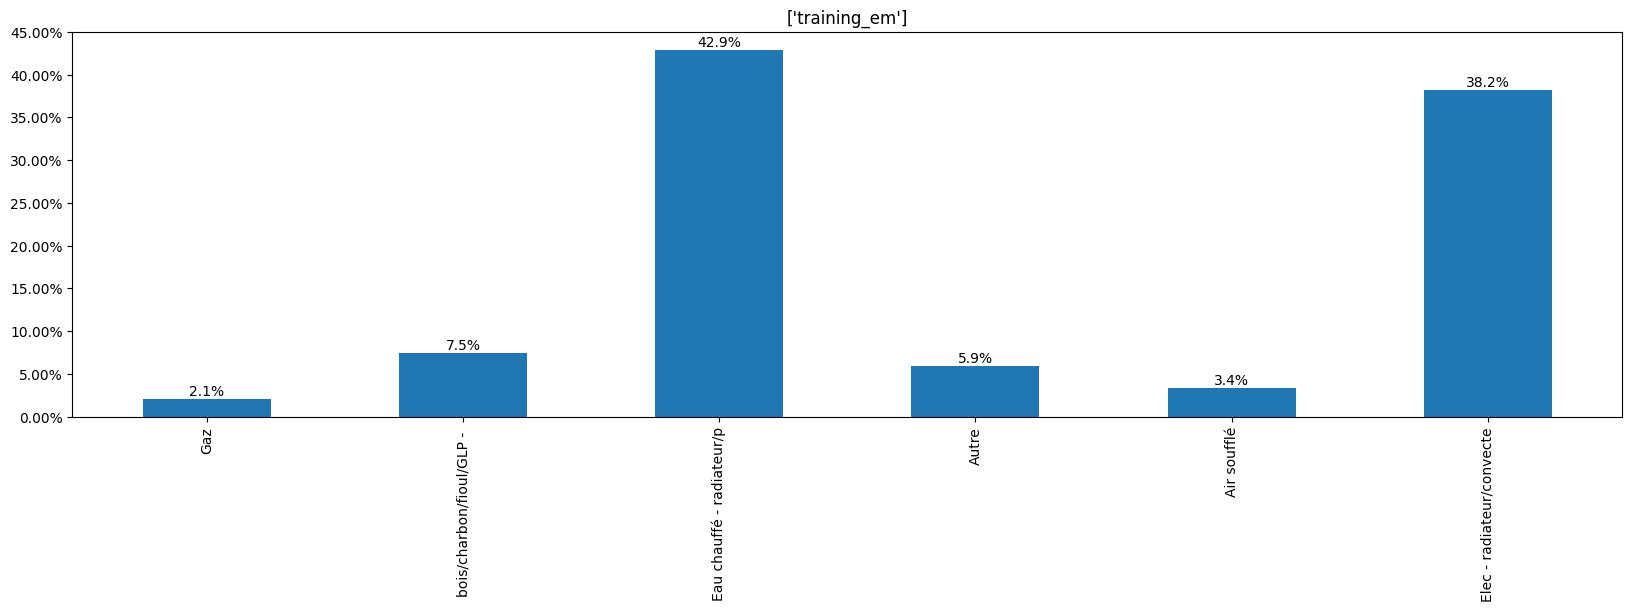

In [10]:
histo(training_surf, 'surface')
compare_repartition([training_prod], 'heating_production')
compare_repartition([training_em], 'heating_emission')

# ML

In [22]:
import numpy as np
# useful
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#linear
from sklearn.linear_model import Ridge

#random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy

# XGboost
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

## fonctions

dataset

In [38]:
# prepare data for ML algo
def prepare_dataset(df, col_X_hot, col_X_not_hot, col_y, y_hot, scale):
    labels = ['dummy']
    for variable in (col_X_not_hot):
        labels.append(variable)
    X_not_hot = df.select(col_X_not_hot).toPandas().to_numpy()
    if len(col_X_hot) > 0:
        for variable in col_X_hot:
            labels.extend(get_labels(variable)['meaning'][1:])
        X_hot = df.select(col_X_hot).toPandas()
        X_hot = OneHotEncoder(drop='first', sparse_output=False).fit_transform(X_hot)
        X = np.column_stack((X_not_hot, X_hot))
    else:
        X = X_not_hot.copy()

    y = df.select(col_y).toPandas().to_numpy()
    if y_hot:
        y = OneHotEncoder(drop='first', sparse_output=False).fit_transform(y)

    # scale data
    if scale:
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y)
    return (X, y, labels)

training

In [13]:
def iterate_params(current, max_hyper):
    for i, (max, curr) in enumerate(zip(max_hyper, current)):
        if max == curr:
            current[i] = 0
        else:
            current[i] += 1
            break
    return current

def choose_params(current, hyperparams):
    hyper = {}
    for hyper_nb, (hyper_name, hyper_choices) in zip(current, hyperparams.items()):
        hyper[hyper_name] = hyper_choices[hyper_nb]
    return hyper

def nb_possibility(max_hyper):
    total = 1
    for nb_poss in max_hyper:
        total *= (nb_poss + 1)
    return total
    
def train_hyper(hyperparams, model, X_train, X_test, y_train, y_test):
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    scores = {}

    # params choice
    current = [0 for _ in range(len(hyperparams))]
    max_hyper = [len(hyperparam) - 1 for hyperparam in hyperparams.values()]
    current_params = choose_params(current, hyperparams)
    all_poss = nb_possibility(max_hyper)

    # training model
    forest_regr = model(**current_params)
    forest_regr.fit(X_train, y_train)

    # register score
    best_score = forest_regr.score(X_test, y_test)
    best_params = current_params.copy()
    scores[tuple([param for param in current_params.values()])] = forest_regr.score(X_test, y_test)

    print(all_poss)
    i = 0
    nb_print = all_poss//4
    while not all(np.equal(current, max_hyper)):
        # choose params
        current = iterate_params(current, max_hyper)
        current_params = choose_params(current, hyperparams)
        if i % nb_print == 0:
            print(i, current)
        i += 1
        forest_regr = model(**current_params)
        forest_regr.fit(X_train, y_train)
        scores[tuple([param for param in current_params.values()])] = forest_regr.score(X_test, y_test)
        if forest_regr.score(X_test, y_test) > best_score:
            best_score = forest_regr.score(X_test, y_test)
            best_params = current_params.copy()
            best_model = deepcopy(forest_regr)
    return (best_model, best_score, best_params, scores)

show_results

In [46]:
def show_hyperparam_opti(scores, hyperparams, ax, model_name):
    x_pos = [i for i in range(len(scores))]
    scores = dict(sorted(scores.items(), key=lambda x:x[1]))

    ax.plot(x_pos, scores.values())
    ax.set_xticks(x_pos, labels=scores.keys(), rotation=90)
    ax.set_title(f'''{model_name}\n{tuple(hyperparams.keys())}''')

def show_result(y_pred, y_true, ax, model_name):
    df = pd.DataFrame(np.column_stack((y_pred, y_true)), columns = ['pred', 'true'])
    df = df.sort_values(by=['true'])
    df.reset_index(inplace = True, drop=True)
    ax.plot(df)
    ax.legend(['pred', 'true'])
    ax.set_ylabel('surface')
    ax.set_xticks([])
    ax.set_title(model_name)

def show_importance(model, labels, ax, model_name):
    y_pos = [i for i in range(len(labels))]
    try:
        ax.barh(y_pos, model.coef_.T.ravel(), align = 'center')
    except:
        try:
            ax.barh(y_pos, model.feature_importances_.T.ravel(), align = 'center')
        except:
            print('pol degree > 1, too many features')
    ax.set_yticks(y_pos, labels = labels)
    ax.set_title(model_name)


In [50]:
# call every functions above
def all_in_one(df, col_X_hots, col_X_not_hots, col_y, y_hot, scale, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4):

    # store best_models
    best_models = {}

    # prepare to plot
    f1, ax_result = plt.subplots(1, len(models), figsize=(15,5), sharey= True)
    f2, ax_hyper = plt.subplots(1, len(models), figsize=(15,5), sharey= True)
    f3, ax_importance = plt.subplots(1, len(models), figsize=(15,20), sharex = True)

    #iterate over models
    for i, (col_X_hot, col_X_not_hot, hyperparams, (model_name, model)) in enumerate(zip(col_X_hots, col_X_not_hots, hyperparams_models, models.items())):
        # prepare data
        X, y, labels = prepare_dataset(training_surf, col_X_hot, col_X_not_hot, col_y, y_hot, scale)
        poly = PolynomialFeatures(degree_poly)
        X_transformed = poly.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=test_size, random_state=random_state)

        # training models
        best_model, best_score, best_params, scores = train_hyper(hyperparams, model, X_train, X_test, y_train, y_test)
        best_models[model_name] = deepcopy(best_model)

        # plot results
        print(best_score, best_params)
        y_pred = best_model.predict(X_test)
        show_result(y_pred, y_test, ax_result[i], model_name)
        show_hyperparam_opti(scores, hyperparams, ax_hyper[i], model_name)
        show_importance(best_model, labels, ax_importance[i], model_name)
    return best_models


## surface

5
0 [1]
1 [2]
2 [3]
3 [4]
0.18932546648858717 {'alpha': 100}
12
0 [1, 0]
3 [1, 1]
6 [1, 2]
9 [1, 3]
0.19100923176208517 {'n_estimators': 200, 'max_depth': 10}
27
0 [1, 0, 0]
6 [1, 2, 0]
12 [1, 1, 1]
18 [1, 0, 2]
24 [1, 2, 2]
0.20281915710131715 {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3}


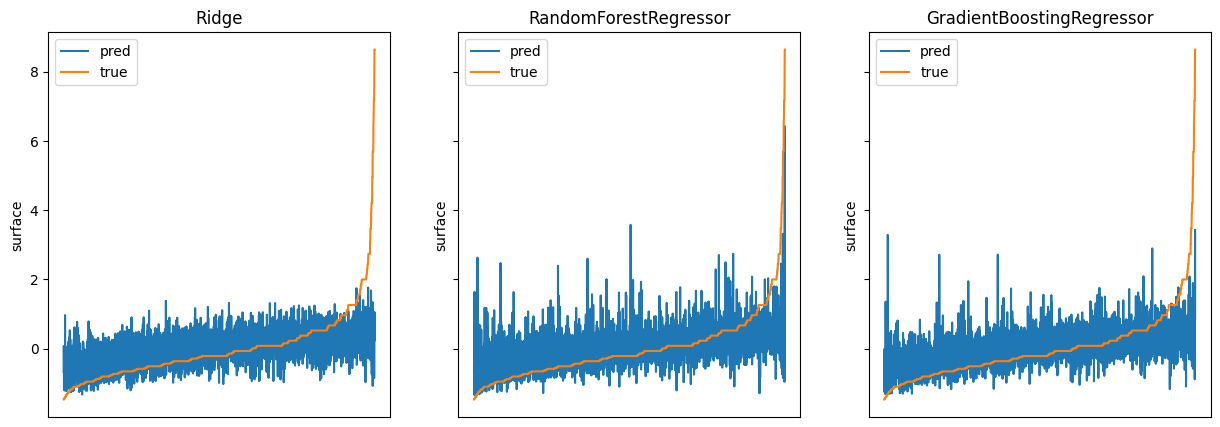

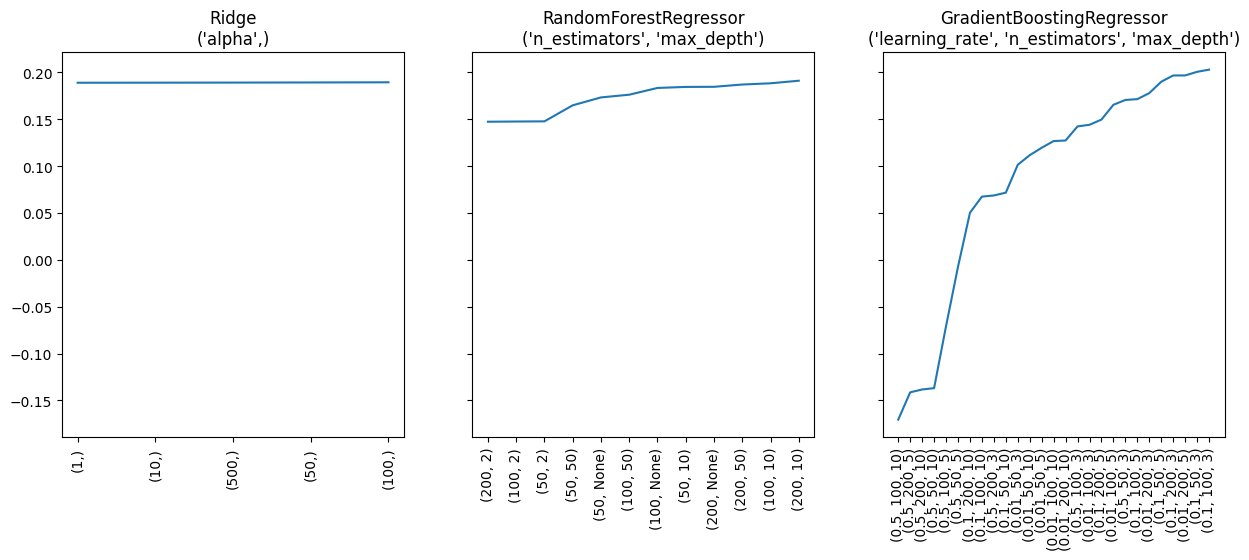

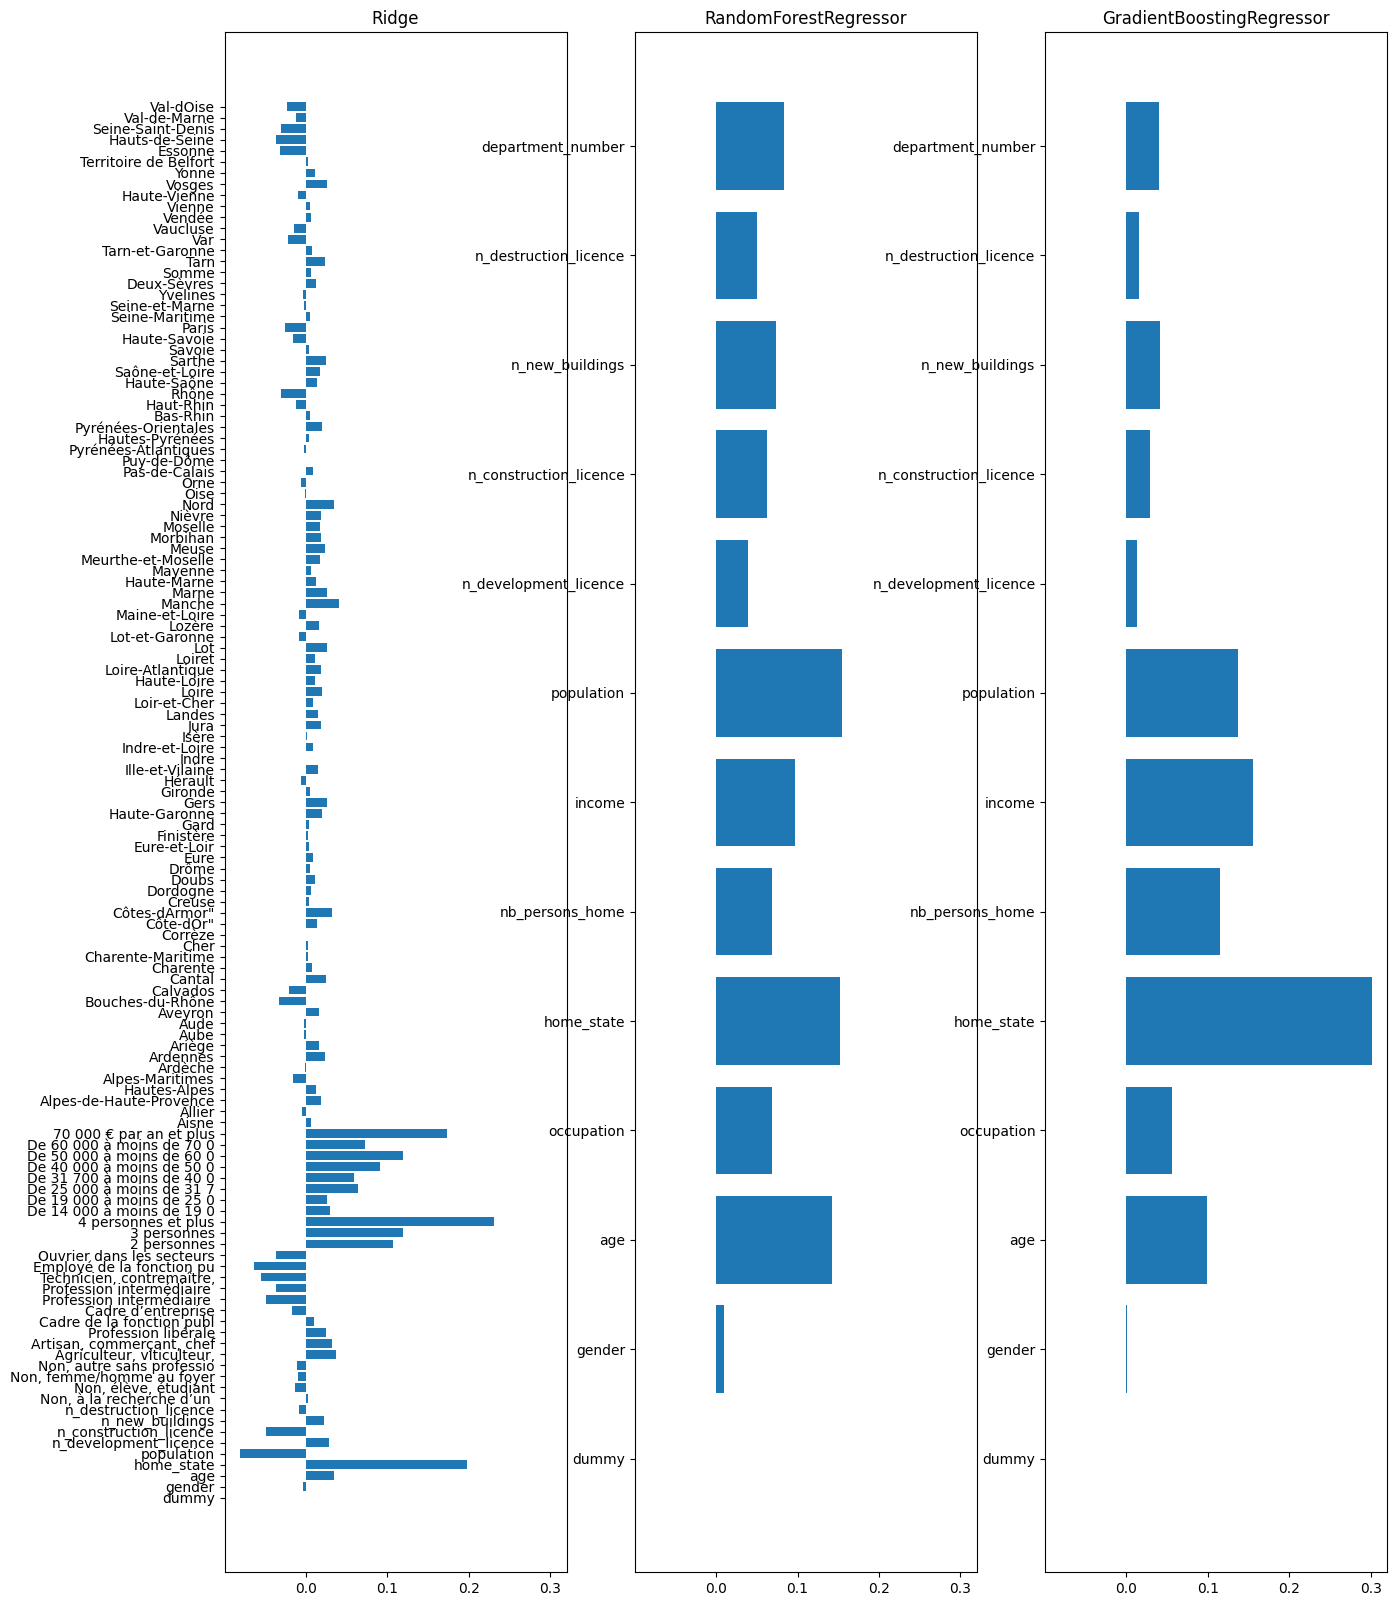

In [49]:
col_X_hot = [['occupation', 'nb_persons_home', 'income', 'department_number'], [], []]
col_y = ['surface']
col_X_not_hot = [
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[0] + col_y ],
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[1] + col_y],
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[2] + col_y]
]

hyperparams_models = [
    {
        'alpha' : [1,10,50,100,500]
    },
    {
        'n_estimators' : [50, 100, 200],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth' : [2, 10, 50, None],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    },
    {
        'learning_rate' : [0.01, 0.1, 0.5],
        'n_estimators' : [50, 100, 200],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth' : [3, 5, 10],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'Ridge' : Ridge,
    'RandomForestRegressor' : RandomForestRegressor,
    'GradientBoostingRegressor' : GradientBoostingRegressor
}
best_model = all_in_one(training_surf, col_X_hot, col_X_not_hot, col_y, False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)
